<a href="https://colab.research.google.com/github/RahilRehan/DeepLearningWithPytorch/blob/master/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                      ])

trainset = datasets.CIFAR10("/data/train", download=True, train=True, transform=transform)
testset = datasets.CIFAR10("/data/test", download=True, train=False, transform=transform)

0it [00:00, ?it/s]

170500096it [00:04, 40007505.21it/s]                               


Extracting /data/train/cifar-10-python.tar.gz to /data/train


0it [00:00, ?it/s]

170500096it [00:04, 42227810.32it/s]                               


Extracting /data/test/cifar-10-python.tar.gz to /data/test


In [0]:
#Global Variables
num_workers = 0  #no idea what this is used to
valid_size = 0.2
batch_size = 32
epochs = 30
valid_loss_min = np.inf

In [0]:
#Dividing training dataset into validation set and training set

total_size = len(trainset)  #length of whole training dataset , =>50000
indices = list(range(total_size))  #indices from 0-5000
#print(indices[:5]) #indices before shuffle
np.random.shuffle(indices)  #shuffle indices to get validation set randomly, inplace operation
#print(indices[:5]) ##indices after shuffle

split_size = int(valid_size*total_size)
train_indices, valid_indices = indices[:split_size], indices[split_size:]

#pytorch magic to obtain data from indices, SubSampler!
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [0]:
#DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shapes of data:  torch.Size([32, 3, 32, 32]) torch.Size([32])
tensor([8, 9, 4, 1, 5])


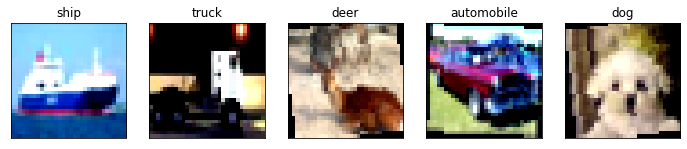

In [0]:
#Let us have look at the data and make sense of it
images, labels = next(iter(trainloader))
print("Shapes of data: ", images.shape, labels.shape)

print(labels[:5])
#Note that the labels has numbers rather than names, this makes our classification easier but we cannot interpret whats inside the image

#Got these class names from google, indices are according labels in dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

#let us view some images

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

images,labels = images[0:5], labels[0:5]

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])


In [0]:
#Yay! Now Let us define the model to train on
#note this is very small model, accuracy may not be high because of low computaion power available... using this model just to test


#note that single input image size was 32*32*3 where height and width are 32 pixels and 3 color channels RGB as depth
#In my final model I want 64 chanels
#I use maxpool to decrease width and hight dimensions
#Finally we connect our output from conv layers to fully connected layers to get 1 Dimensional output


class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1) 
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1) 

    self.pool = nn.MaxPool2d(2, stride = 2)
    self.fc1 = nn.Linear(64*4*4, 512)
    self.fc2 = nn.Linear(512, 10)

    self.dropout = nn.Dropout(p=0.25)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))  #input is 3*32*32      output is 16*16*16
    x = self.pool(F.relu(self.conv2(x)))  #input is 16*16*16     output is 32*8*8
    x = self.pool(F.relu(self.conv3(x)))  #input is 32*8*8       output is 64*4*4

    x = self.dropout(x)
    x = x.view(-1, 64*4*4)

    x = self.dropout(F.relu(self.fc1(x)))
    x = self.fc2(x)
    return x
    


In [0]:
#Initial model and check GPU
model = Classifier()
print(model)


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

train_on_gpu = True if device == "cuda" else False

if(train_on_gpu):
  model.to(device)

Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
cuda


In [0]:
#optimizers and loss initialization
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [0]:
for e in range(epochs):
  train_loss = 0.0
  valid_loss = 0.0
  for data, target in trainloader:
    if train_on_gpu:
      data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*data.shape[0]


  model.eval()
  with torch.no_grad():
    for data, target in validloader:
      if train_on_gpu:
        data, target = data.to(device), target.to(device)

      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item()*data.shape[0]
  model.train()

  train_loss = train_loss/len(trainloader.sampler)
  valid_loss = valid_loss/len(validloader.sampler)

  print("Epoch {0}   Training loss: {1}, Validation loss: {2}".format(e, train_loss, valid_loss))

  if(valid_loss < valid_loss_min):
    print("Validation Loss decreased from {0} to {1}, Saving Model........".format(valid_loss_min, valid_loss))
    torch.save(model.state_dict(), 'model_aug.pt')
    valid_loss_min = valid_loss


Epoch 0   Training loss: 2.2973416862487794, Validation loss: 2.287272257423401
Validation Loss decreased from inf to 2.287272257423401, Saving Model........
Epoch 1   Training loss: 2.2564107955932617, Validation loss: 2.1840078747749327
Validation Loss decreased from 2.287272257423401 to 2.1840078747749327, Saving Model........
Epoch 2   Training loss: 2.053321664047241, Validation loss: 1.9340928545951843
Validation Loss decreased from 2.1840078747749327 to 1.9340928545951843, Saving Model........
Epoch 3   Training loss: 1.892741130065918, Validation loss: 1.837496978855133
Validation Loss decreased from 1.9340928545951843 to 1.837496978855133, Saving Model........
Epoch 4   Training loss: 1.7779617141723634, Validation loss: 1.7141507767677306
Validation Loss decreased from 1.837496978855133 to 1.7141507767677306, Saving Model........
Epoch 5   Training loss: 1.6984104095458985, Validation loss: 1.6887458391189576
Validation Loss decreased from 1.7141507767677306 to 1.688745839118

In [0]:
model.load_state_dict(torch.load('model_aug.pt'))

<All keys matched successfully>

In [0]:
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(images.shape(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

TypeError: ignored

In [0]:
images, lables = next(iter(testloader))
print(images.shape[0])

32


In [0]:
#overall accuracy
totac = 0
for i in range(10):
  totac += 100 * class_correct[i] / class_total[i])
  